In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

In [3]:
housing = pd.read_csv("housing.csv")

In [4]:
print(housing.shape)

(20640, 10)


In [5]:
print(housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


In [6]:
housing.isnull().sum()*100/housing.shape[0]

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.002907
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

In [7]:
housing.dropna(inplace=True)

In [8]:
housing.isnull().sum()*100/housing.shape[0]

longitude             0.0
latitude              0.0
housing_median_age    0.0
total_rooms           0.0
total_bedrooms        0.0
population            0.0
households            0.0
median_income         0.0
median_house_value    0.0
ocean_proximity       0.0
dtype: float64

In [9]:
print(housing.describe())

          longitude      latitude  housing_median_age   total_rooms  \
count  20433.000000  20433.000000        20433.000000  20433.000000   
mean    -119.570689     35.633221           28.633094   2636.504233   
std        2.003578      2.136348           12.591805   2185.269567   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1450.000000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.720000           37.000000   3143.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20433.000000  20433.000000   20433.000000   
mean       537.870553   1424.946949    499.433465       3.871162   
std        421.385070   1133.208490    382.299226       1.899291   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

In [10]:
print(housing.isnull().sum())

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


In [11]:
numeric_vars = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                'households', 'median_income', 'median_house_value']

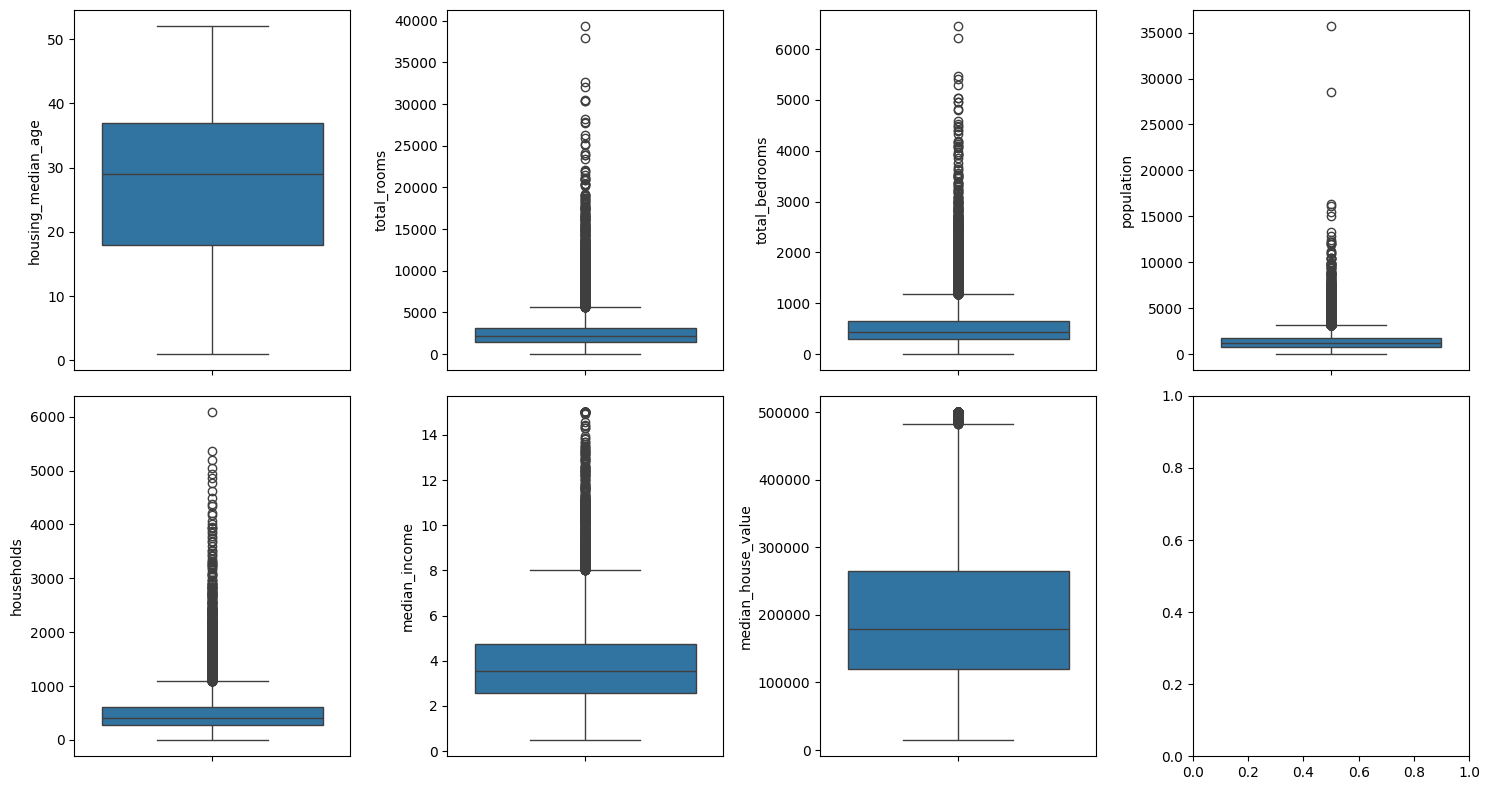

In [12]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
for i, var in enumerate(numeric_vars):
    row = i // 4
    col = i % 4
    sns.boxplot(y=housing[var], ax=axs[row, col])
plt.tight_layout()
plt.show()

In [13]:
def remove_outliers(df, var):
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[var] >= Q1 - 1.5*IQR) & (df[var] <= Q3 + 1.5*IQR)]
    return df

In [14]:
housing = remove_outliers(housing, 'median_house_value')
housing = remove_outliers(housing, 'total_rooms')
housing = remove_outliers(housing, 'total_bedrooms')
housing = remove_outliers(housing, 'median_income')

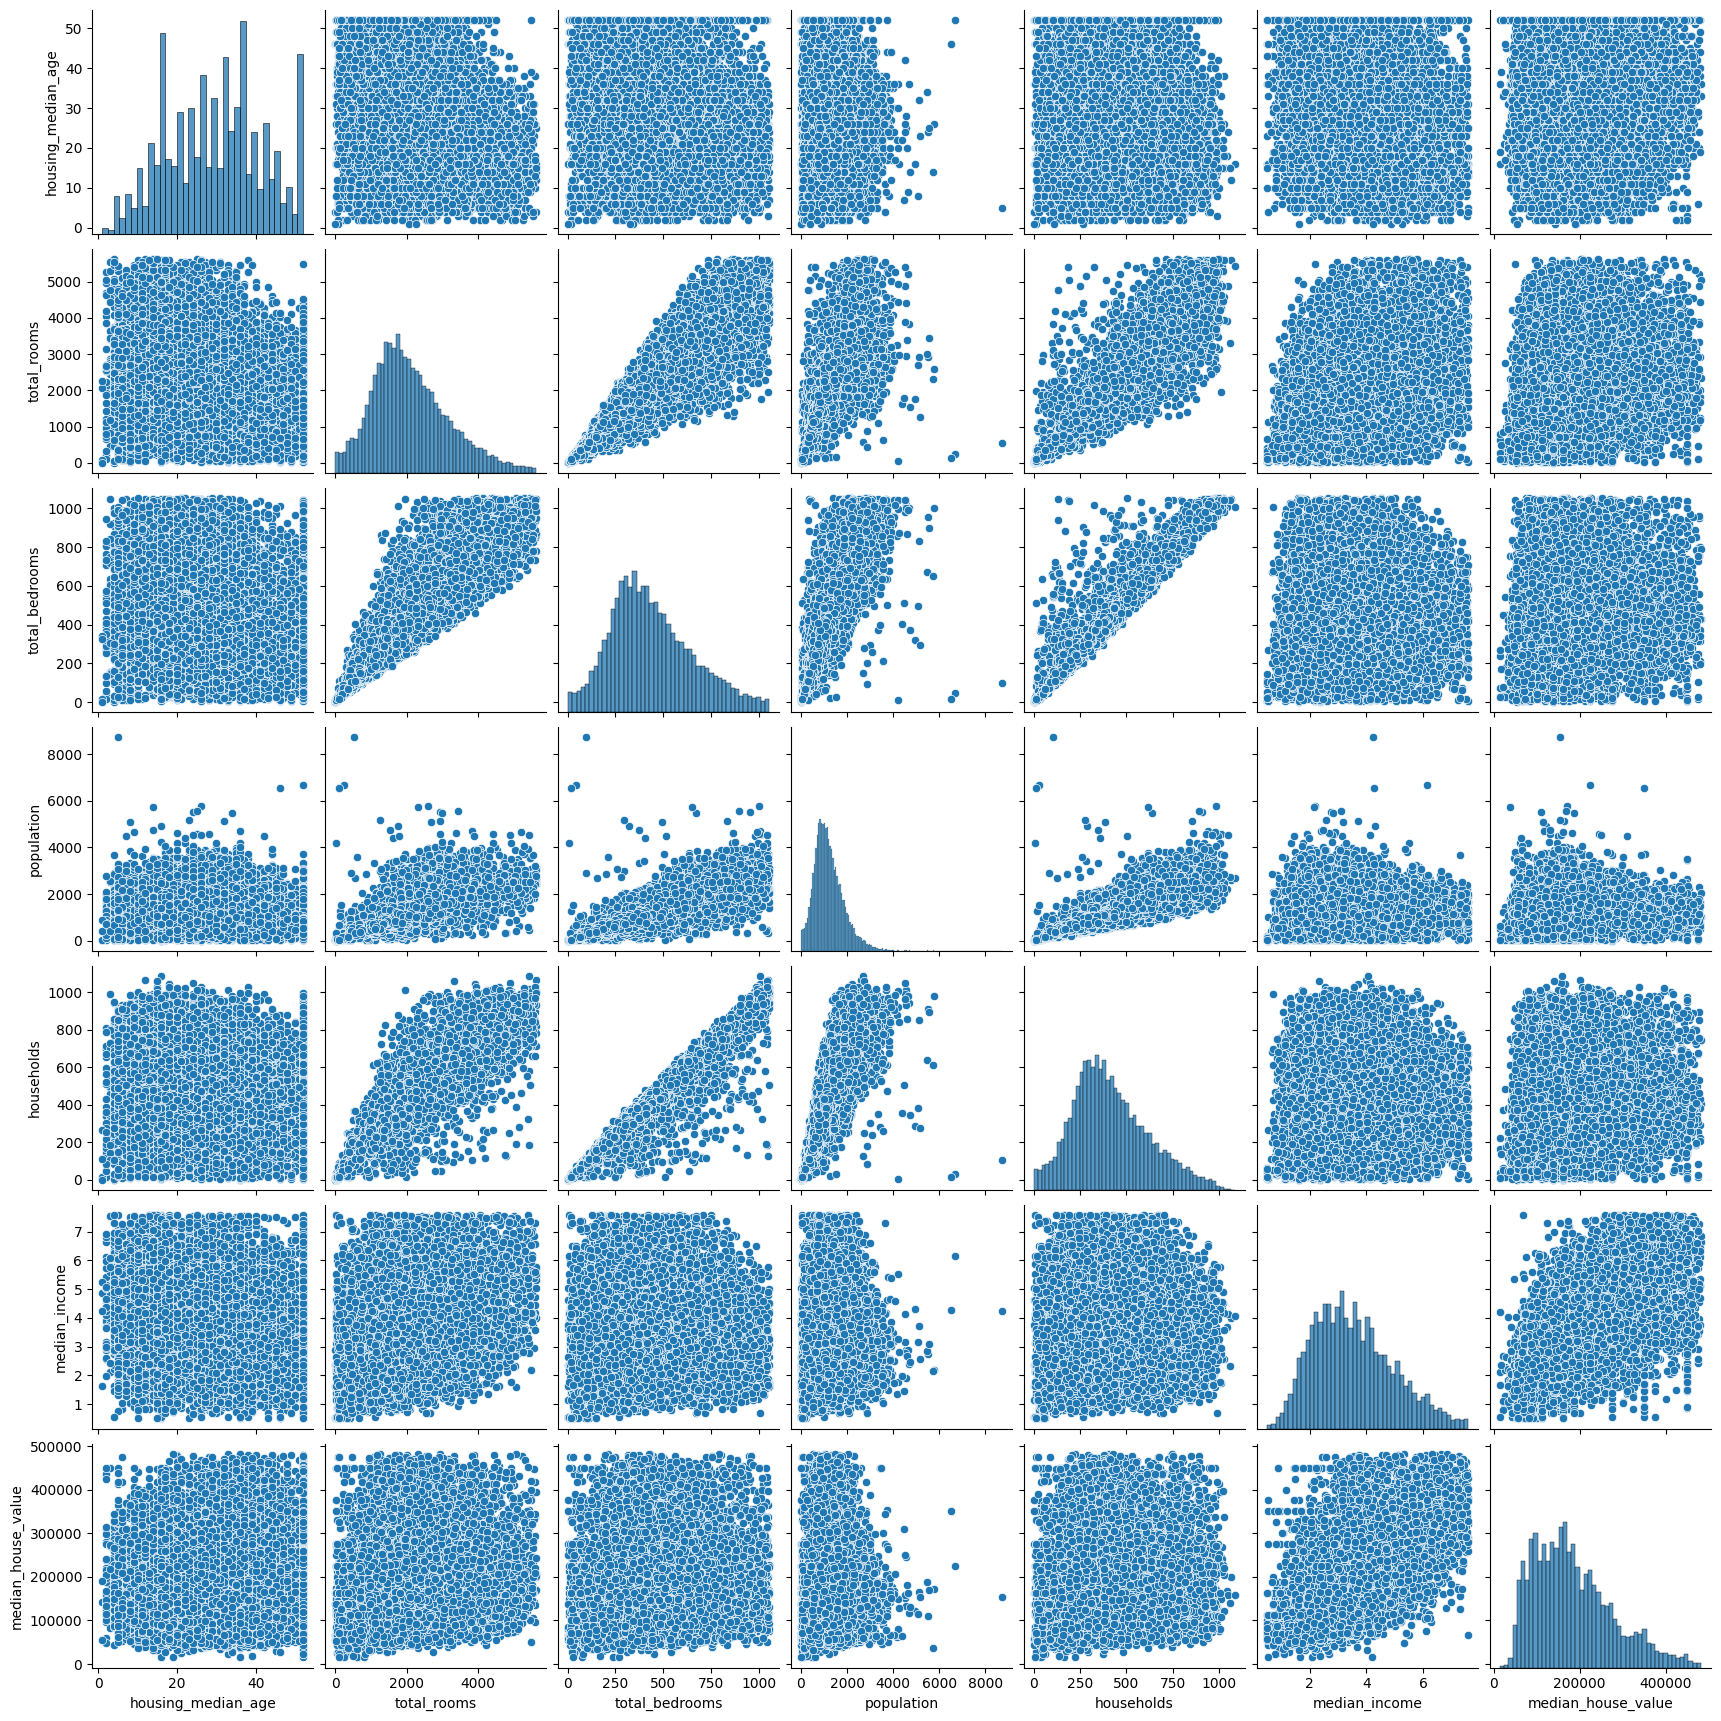

In [15]:
sns.pairplot(housing[numeric_vars])
plt.show()

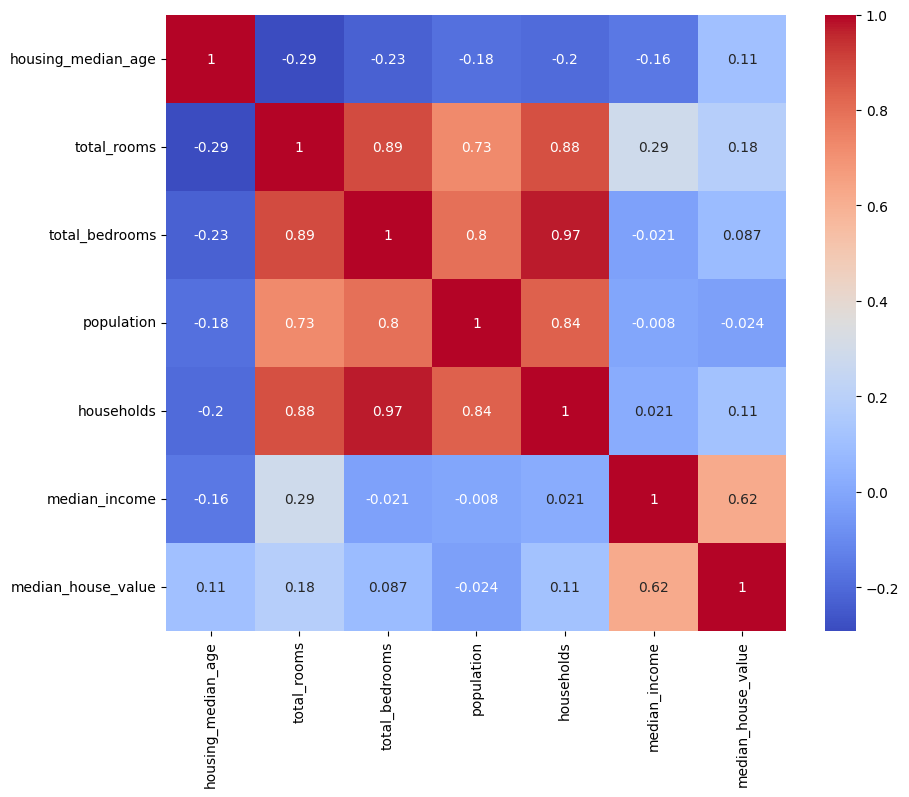

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(housing[numeric_vars].corr(), annot=True, cmap='coolwarm')
plt.show()

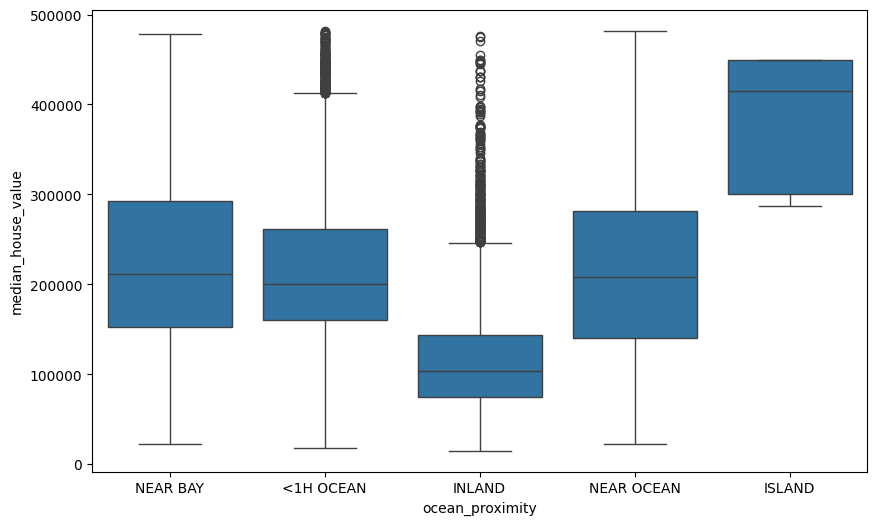

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='ocean_proximity', y='median_house_value', data=housing)
plt.show()

In [18]:
status = pd.get_dummies(housing['ocean_proximity'], drop_first=True)
housing = pd.concat([housing, status], axis=1)
housing.drop(['ocean_proximity'], axis=1, inplace=True)

In [19]:
np.random.seed(0)
df_train, df_test = train_test_split(housing, train_size=0.7, test_size=0.3, random_state=100)

In [20]:
scaler = MinMaxScaler()

In [21]:
num_vars = numeric_vars.copy()
num_vars.remove('median_house_value')

In [22]:
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train['median_house_value'] = scaler.fit_transform(df_train[['median_house_value']])

In [23]:
y_train = df_train.pop('median_house_value')
X_train = df_train

In [24]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [25]:
rfe = RFE(estimator=lm, n_features_to_select=6)  
rfe = rfe.fit(X_train, y_train)

In [26]:
print(list(zip(X_train.columns, rfe.support_, rfe.ranking_)))

[('longitude', np.False_, np.int64(4)), ('latitude', np.False_, np.int64(5)), ('housing_median_age', np.False_, np.int64(3)), ('total_rooms', np.True_, np.int64(1)), ('total_bedrooms', np.True_, np.int64(1)), ('population', np.True_, np.int64(1)), ('households', np.True_, np.int64(1)), ('median_income', np.True_, np.int64(1)), ('INLAND', np.False_, np.int64(2)), ('ISLAND', np.True_, np.int64(1)), ('NEAR BAY', np.False_, np.int64(6)), ('NEAR OCEAN', np.False_, np.int64(7))]


In [27]:
selected_features = X_train.columns[rfe.support_]
print(selected_features)

Index(['total_rooms', 'total_bedrooms', 'population', 'households',
       'median_income', 'ISLAND'],
      dtype='object')


In [28]:
X_train_rfe = X_train[selected_features]
X_train_rfe = sm.add_constant(X_train_rfe)

In [29]:
print(X_train_rfe.dtypes)

const             float64
total_rooms       float64
total_bedrooms    float64
population        float64
households        float64
median_income     float64
ISLAND               bool
dtype: object


In [30]:
X_train_rfe = X_train_rfe.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')

In [31]:
print(X_train_rfe.isna().sum())
print(y_train.isna().sum())

X_train_rfe = X_train_rfe.dropna()
y_train = y_train[X_train_rfe.index] 

const             0
total_rooms       0
total_bedrooms    0
population        0
households        0
median_income     0
ISLAND            0
dtype: int64
0


In [33]:
X_train_rfe['ISLAND'] =X_train_rfe['ISLAND'].astype(int) 

In [34]:
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     1905.
Date:                Wed, 04 Jun 2025   Prob (F-statistic):               0.00
Time:                        07:36:48   Log-Likelihood:                 6484.4
No. Observations:               12126   AIC:                        -1.295e+04
Df Residuals:                   12119   BIC:                        -1.290e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0086      0.005      1.